

```
<Diplodatos 2021>
<Analisis y VIsualizacion de Datos>

<Integrantes de Grupo>
Martin Rodriguez
Luis Juncos
Pablo Carrazana
Martin Peñas
```



#Ejercicio 1 - Analisis descriptivo

# ¿Cuáles son los lenguajes de programación asociados a los mejores salarios?

## Lectura del Dataset

In [ ]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import re
import requests
import scipy.stats
from scipy.stats import chi2_contingency

seaborn.set_context('talk')

In [ ]:
url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv'
df = pd.read_csv(url)
raw_data=df.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5643 entries, 0 to 6094
Data columns (total 48 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   profile_gender                                5643 non-null   object 
 1   profile_age                                   5643 non-null   int64  
 2   work_country                                  5643 non-null   object 
 3   work_province                                 5643 non-null   object 
 4   profile_years_experience                      5643 non-null   float64
 5   work_years_in_company                         5643 non-null   float64
 6   work_years_in_current_position                5643 non-null   float64
 7   work_people_in_charge_of                      5643 non-null   int64  
 8   profile_studies_level                         5643 non-null   object 
 9   profile_studies_level_state                   5643 non-null   o

##Seleccionar las filas relevantes para analizar. 
Esto incluye la eliminación de valores extremos y erróneos, pero también puede enfocar el análisis en una sub-población. Por ejemplo, se pueden limitar a personas con un salario mayor que 10000 pesos, o a las personas que trabajan sólo en "Data Science", pero deben justificar su elección y reformular la pregunta inicial de ser necesario.
* Obtener una lista de los lenguajes de programación más populares. Decidir cuántos y cuáles seleccionan para incluir en el análisis.
* Para cada una de las otras columnas del punto anterior, elegir los rangos o valores seleccionan para incluir en el análisis.

Quitamos los salarios en primer lugar por debajo del salario mínimo, vital y movil (SMVM) que conforme lo publicara el MINISTERIO DE PRODUCCIÓN Y TRABAJO CONSEJO NACIONAL DEL EMPLEO, LA PRODUCTIVIDAD Y EL SALARIO MÍNIMO, VITAL Y MÓVIL se encontraba en $ 16.875,00 a partir de Octubre de 2019.


In [ ]:
SMVM= 16875
df=df[df['salary_monthly_NETO']>SMVM]
df.salary_monthly_NETO.describe().round()

count       5643.0
mean       98823.0
std        96976.0
min        17000.0
25%        55000.0
50%        80000.0
75%       108106.0
max      2080000.0
Name: salary_monthly_NETO, dtype: float64

##Observamos los cuantiles
Analizamos distintos en el rango de los salarios más altos para endender como se distribuyen. 

A partir del primer código, se puede observar a simple vista como se diferencia los salarios en el cuantil 0.998 del resto. Gráficamente en el distplot la apresiación no es tan notoria.  

In [ ]:
cuant = pd.DataFrame(df['salary_monthly_NETO'].quantile([0.85, 0.90, 0.95, 0.98, 0.99, 0.995, 0.998]))
cuant = cuant.rename_axis('index').reset_index()
cuant["colour"] = 'b', 'g', 'r', 'c', 'm', 'y', 'k'
print(cuant)

   index  salary_monthly_NETO colour
0  0.850            130000.00      b
1  0.900            155000.00      g
2  0.950            220000.00      r
3  0.980            378320.00      c
4  0.990            500000.00      m
5  0.995            650000.00      y
6  0.998            960963.12      k


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Observando los Cuantiles')

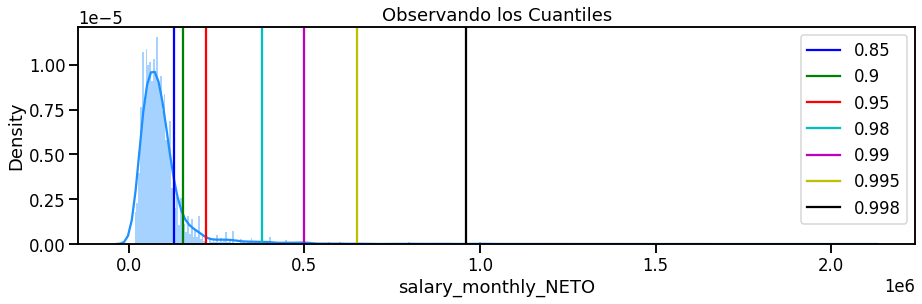

In [ ]:
#análisis gráfico de la distribución de salarios y como se ubican en distintos cuantiles superiores. 
df.count
plt.figure(figsize=(15,4))
seaborn.distplot(df["salary_monthly_NETO"], bins=400, color="dodgerblue")
for idx in cuant.itertuples():
  plt.axvline(x= idx.salary_monthly_NETO, ymin=0, c= idx.colour, label=idx.index)
plt.legend()
plt.title("Observando los Cuantiles")


A partir de la observación anterior (salarios notoriamente elevados en los dos últimos cuantiles) analizamos de manera gráfica, que % de personas declararon tener su sueldo dolarizado en los cuantiles elegidos. 
Se observa que al tomar como "corte" el cuantil 0,95 dejamos fuera del análisis datos de muestras que declararon un sueldo mayor a $ 210.000 mensuales. A partir de dicho monto, se puede observar que la mayoría declararon que poseen un sueldo dolarizado, los que decidimos dejar fuera del análisis ya que no podrían ser directamente comparados con los salarios en pesos porque desconocemos las condiciones de como se efectivisa ese salario en USD a pesos. 

In [ ]:
#En el siguiente código generamos df para cada cuantil que nos permitirá realizar el analisis a continuación. 
out085 = df[df['salary_monthly_NETO'] > df['salary_monthly_NETO'].quantile(0.85)]
out090 = df[df['salary_monthly_NETO'] > df['salary_monthly_NETO'].quantile(0.90)]
out095 = df[df['salary_monthly_NETO'] > df['salary_monthly_NETO'].quantile(0.95)]
out098 = df[df['salary_monthly_NETO'] > df['salary_monthly_NETO'].quantile(0.98)]
out099 = df[df['salary_monthly_NETO'] > df['salary_monthly_NETO'].quantile(0.99)]
out0995 = df[df['salary_monthly_NETO'] > df['salary_monthly_NETO'].quantile(0.995)]
out0998 = df[df['salary_monthly_NETO'] > df['salary_monthly_NETO'].quantile(0.998)]

In [ ]:
#en la siguiente líneas de código obtenemos el % de salario USD para cada cuantil
out_usd = pd.DataFrame()
out_usd["Q085"] = out090["salary_in_usd"].value_counts() / len(out085)
out_usd["Q090"] = out090["salary_in_usd"].value_counts() / len(out090)
out_usd["Q095"] = out095["salary_in_usd"].value_counts() / len(out095)
out_usd["Q098"] = out098["salary_in_usd"].value_counts() / len(out098)
out_usd["Q099"] = out099["salary_in_usd"].value_counts() / len(out099)
out_usd["Q0995"] = out0995["salary_in_usd"].value_counts() / len(out0995)
out_usd["Q0998"] = out0998["salary_in_usd"].value_counts() / len(out0998)

out_usd = out_usd.transpose()

<function matplotlib.pyplot.show>

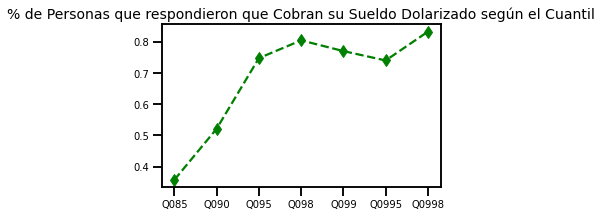

In [ ]:
out_usd = out_usd.rename(columns={"Mi sueldo está dolarizado":"%Dolarizado"})
plt.figure(figsize=(5,3))
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 
plt.plot(out_usd["%Dolarizado"], "g--d")
plt.title("% de Personas que respondieron que Cobran su Sueldo Dolarizado según el Cuantil", fontsize=14)
plt.show

El gráfico a continuación muestra la distribución de salarios netos sin lo salarios sobre el cuantil 0.95 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


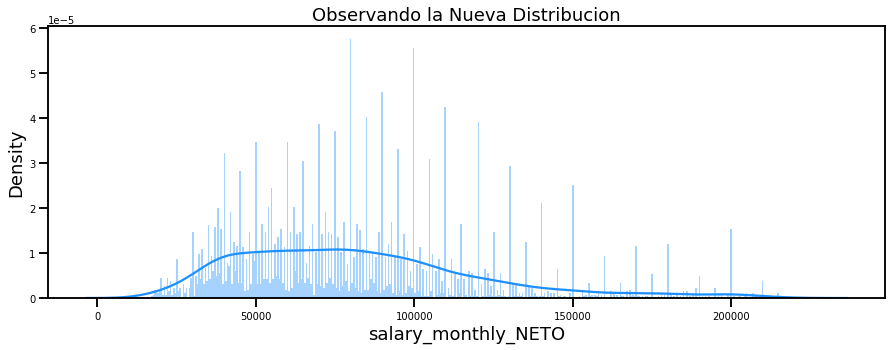

In [ ]:
k = 95
percentile_elegido = df['salary_monthly_NETO'].quantile(k/100)
plt.figure(figsize=(15,5))
plt.title("Observando la Nueva Distribucion")
df_without_outliers = df[df["salary_monthly_NETO"] < percentile_elegido]#[salary_col]
seaborn.distplot(df_without_outliers["salary_monthly_NETO"], bins=400, color='dodgerblue')

##Selección de columnas relevantes para analizar
Nuestro análisis se centrará en entender como impactan los salarios en función de el tipo de lenguage de progrmación. En este sentido vamos a separar Desarrolladores de No Desarrolladores ya que consideramos que los primeros cobran un salario dependiendo de su *expertise* en uno o varios lenguajes de programación. 

In [ ]:
#copiamos df_withou_outliers del análisis anterior en df.
df = df_without_outliers.copy()

In [ ]:
#selección de columnas relevantes
relevant_columns = ['tools_programming_languages', 'salary_monthly_NETO', 'work_role']

###Preparación de datos: todo lo necesario para facilitar la manipulación de datos y estudio de variables.

In [ ]:
# Convert the comma-separated string of languages to a list of string.
# Remove 'ninguno de los anteriores' option, spaces and training commas.
def split_languages(languages_str):
  if not isinstance(languages_str, str):
    return []
  # Remove 'other' option
  languages_str = languages_str.lower()\
    .replace('ninguno de los anteriores', '')
  # Split string into list of items
  # Remove spaces and commas for each item
  return [lang.strip().replace(',', '')
          for lang in languages_str.split()]

# Create a new column with the list of languages
df.loc[:, 'cured_programming_languages'] = df.tools_programming_languages\
    .apply(split_languages)
if 'cured_programming_languages' not in relevant_columns:
    relevant_columns.append('cured_programming_languages') 

# Duplicate each row of df for each programming language
# mentioned in the response.
# We only include in df_lang the columns we are going to analyze later, so we
# don't duplicate innecesary information.
df_lang = df.cured_programming_languages\
    .apply(pd.Series).stack()\
    .reset_index(level=-1, drop=True).to_frame()\
    .join(df[relevant_columns])\
    .rename(columns={0: 'programming_language'})
# Horrible programming style! But a lot of data science code can be written with
# as concatenations of functions (pipelines), and there's no elegant way of
# doing that on Python.
df_lang[:5]

,programming_language,tools_programming_languages,salary_monthly_NETO,work_role,cured_programming_languages
0,ninguno,Ninguno,43000.0,Consultant,[ninguno]
1,html,"HTML, Javascript, Python",63000.0,Developer,"[html, javascript, python]"
1,javascript,"HTML, Javascript, Python",63000.0,Developer,"[html, javascript, python]"
1,python,"HTML, Javascript, Python",63000.0,Developer,"[html, javascript, python]"
2,ninguno,Ninguno,127000.0,Infosec,[ninguno]


###Análisis de sub-población

Como explicamos anteriormente, vamos a seleccionar la sub-población de desarrolladores. 

En primer instancia analizamos la variable work_role en búsqueda de roles relacionados a desarrolladores. Hay varios, en su mayoría bajo la descripción Developer. 



In [ ]:
#Analizamos a continuación los distintos roles y encontramos Developer y Desarrollador en un mismo respuesta junto a otros roles. 
df_lang['work_role'].unique() 

array(['Consultant', 'Developer', 'Infosec', 'SysAdmin / DevOps / SRE',
       'Manager / Director', 'Technical Leader',
       'Data Scientist / Data Engineer', 'DBA', 'Project Manager',
       'Business Analyst', 'QA / Tester', 'Architect', 'Product Manager',
       'Designer', 'BI Analyst / Data Analyst', 'Middleware',
       'Storage / Backup', 'Networking', 'HelpDesk', 'UX',
       'Ux User Research Analyst', 'Sales / Pre-Sales', 'Team leader',
       'Microinformatica', 'Technical Writer',
       'Implementadora de software ', 'Desarrollador BI',
       'Martech Specialist', 'Maquetador/Diseño UI', 'Service manager',
       'Release Manager', 'Access Management Analyst',
       'DevOps Cloud Engineer', 'Soporte e Infraestructura',
       'Recruiter / HR', 'Finance', 'Data Visualization',
       'Implementador de Software', 'back end', 'Software Engineer',
       'Scrum Master', 'NLP', 'Presales architect', 'NOC',
       'QA automation Technical Leader', 'Telecomunicaciones', 'Cto

In [ ]:
#Hacemos curacion del campo work_role, todo en minuscula en una columna nueva work_role_clean
df_lang['work_role_clean'] = df_lang['work_role'].apply(lambda x: str.lower(x))
df_lang.head(3)

,programming_language,tools_programming_languages,salary_monthly_NETO,work_role,cured_programming_languages,work_role_clean
0,ninguno,Ninguno,43000.0,Consultant,[ninguno],consultant
1,html,"HTML, Javascript, Python",63000.0,Developer,"[html, javascript, python]",developer
1,javascript,"HTML, Javascript, Python",63000.0,Developer,"[html, javascript, python]",developer


In [ ]:
#Buscamos todos los que respondieron developer y desarrollador y generamos un nuevo DF con las coincidencias. 
df_developer = df_lang[df_lang['work_role_clean'].str.contains("developer|desarrollador")]

In [ ]:
#observamos que las muestras
df_developer['work_role_clean'].value_counts()

developer                                                                                                                       7799
firmware developer                                                                                                                10
trabajo como desarrollador back, pero también tengo que estar haciendo de analista , dba, dev frontend y a veces de helpdesk       6
analista/desarrollador                                                                                                             6
desarrollador  / líder técnico / analista técnico funcional                                                                        6
software developer- computer vision full stack                                                                                     5
full developer                                                                                                                     4
help desk/software architect/developer                               

Analizamos los 10 lenguajes mas populares dentro del dataset, es decir, los que más ocurrencias tienen.

In [ ]:
#generamos el DF most_important_lang con los lenguajes más importantes de la subpoblación Desarrolladores
df_lang_work = df_developer.copy()
language_count = df_lang_work.programming_language.value_counts()\
    .reset_index()\
    .rename(columns={'index': 'language', 'programming_language': 'frequency'})
most_important_lang = language_count[:10]
most_important_lang

,language,frequency
0,javascript,1395
1,html,967
2,sql,906
3,css,734
4,java,711
5,typescript,493
6,.net,421
7,c#,408
8,php,363
9,python,342


Cruzamos los 10 lenguajes más populares de nuestro dataset con los más demandados según GitHub https://octoverse.github.com/#chart-rely-on-oss

Observamos que nuestro ds incluye 5 de los 6 identificados por GitHub. El 6to es Ruby, y si bien no está en nuestro ds, nos parece interesante analizar el nivel de salario para este lenguage que quizás podría ser una oportunidad para un mercado con buenos salarios y poca oferta de desarrolladores. 

In [ ]:
mas_demandados= ['php','java','javascript','.net','python','ruby']

In [ ]:
mask_2 = df_lang_work['programming_language'].apply(lambda x: any(item for item in mas_demandados if item in x))
#DF con los lenguajes más demandados. 
df_lang_work_dem = df_lang_work[mask_2]

In [ ]:
df_lang_work_dem[:3]

,programming_language,tools_programming_languages,salary_monthly_NETO,work_role,cured_programming_languages,work_role_clean
1,javascript,"HTML, Javascript, Python",63000.0,Developer,"[html, javascript, python]",developer
1,python,"HTML, Javascript, Python",63000.0,Developer,"[html, javascript, python]",developer
4,javascript,"CSS, HTML, Javascript, SQL, TypeScript",106000.0,Developer,"[css, html, javascript, sql, typescript]",developer


In [ ]:
df_lang_work_dem.programming_language.value_counts()

javascript    1395
java           711
.net           421
php            363
python         342
ruby            49
Name: programming_language, dtype: int64

###Conclusiones
Reliazamos a continuación un describe y un boxplot para analizar el nivel de salario vs el lenguaje. Javascript presenta una importante cantidad de outliers y no representa el lenguaje con los salarios más altos. Es también el lenguaje con más muestras.Java y Python poseen los salarios medios más elevados y casualmente Ruby viene detrás. Este último lenguaje posee el salario más alto, fueras de los outliers. Los mínimos en varios lenguajes se repiten, muy probablemente correspondan a la misma persona. En gral todos los lenguajes presentan un salario mensual promedio muy parecido. 

In [ ]:
df_lang_work_dem.groupby('programming_language').describe()

salary_monthly_NETO                ...                    
                                   count          mean  ...       75%       max
programming_language                                    ...                    
.net                               421.0  70590.233990  ...   85000.0  213870.0
java                               711.0  81176.916878  ...  100000.0  210000.0
javascript                        1395.0  75566.156373  ...   93385.0  213870.0
php                                363.0  71208.194490  ...   86631.5  200000.0
python                             342.0  81290.721988  ...  100000.0  200000.0
ruby                                49.0  80050.306122  ...  100000.0  202380.0

[6 rows x 8 columns]

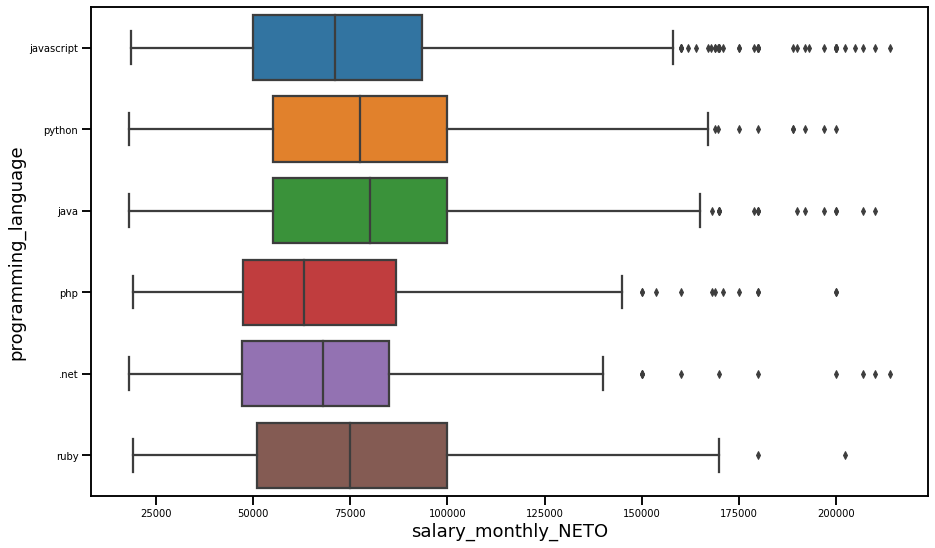

In [ ]:
plt.figure(figsize=(15,9))
seaborn.boxplot(data=df_lang_work_dem,x='salary_monthly_NETO',y='programming_language')

Exploramos también el dataset con un swarmplot. En el gráfico podemos ver la distribución y frecuencia de la variable Salario Neto de la encuesta de Sysarmy de acuerdo a los lenguajes de programación más utilizados, obtenidos del informe Octoverse de Github. Se observa que los lenguajes Javascript y Java son los que más respuestas generaron. El lenguaje que menos respuestas generó fue Ruby pero aun así reportó casos en la parte superior de la distribución del Salario Mensual Neto, como indicamos anteriormente. 

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 45.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 15.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


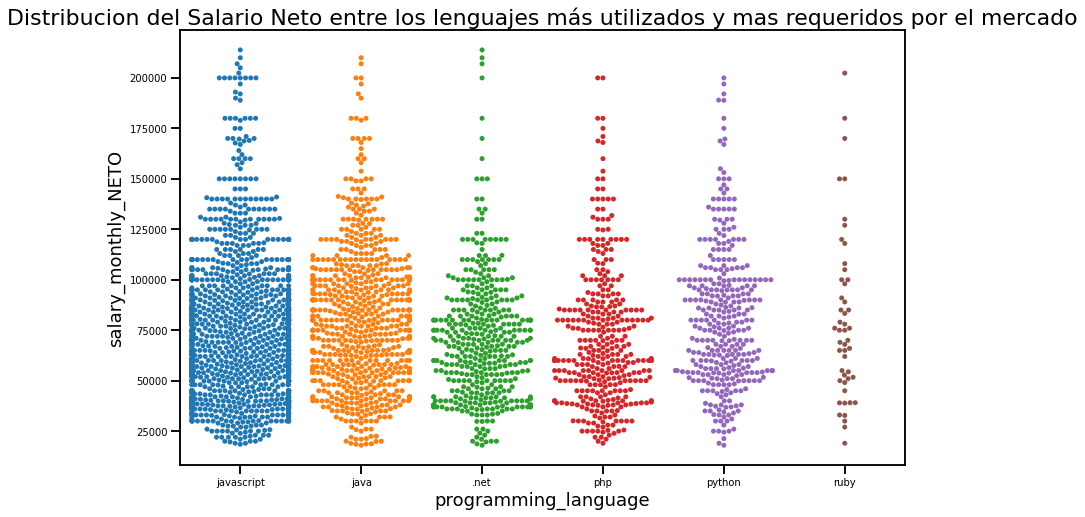

In [ ]:
order = pd.DataFrame(df_lang_work_dem['programming_language'].value_counts()).index
plt.figure(figsize=(13,8))
plt.title("Distribucion del Salario Neto entre los lenguajes más utilizados y mas requeridos por el mercado", fontsize=22)
seaborn.swarmplot(x="programming_language", y="salary_monthly_NETO", data=df_lang_work_dem, order=order)

# Ejercicio 2: Densidades y varias varialbes

##Selección de columnas relevantes

In [ ]:
#traemos el DF original. 
df=raw_data.copy()

In [ ]:
#seleccionamos la columnas relevantes a analizar
columnas_relevantes = ['salary_monthly_NETO','work_role','profile_years_experience','salary_satisfaction','work_province','profile_studies_level','tools_programming_languages','salary_in_usd','profile_age','work_years_in_company']

##Eliminación de datos NaN, datos erroneos y extremos.

In [ ]:
#Reemplazar el string Mi sueldo está dolarizado por un Si y los NaN con un No
df['salary_in_usd'].fillna('No',inplace=True)
df['salary_in_usd'] = df['salary_in_usd'].str.replace('Mi sueldo está dolarizado','Si')

In [ ]:
#2) Análisis de cada columna y búsqueda de valores extraños. 
#se observan valores fuera de lo común, como:
#Salarios superiores a los 2M de pesos, Años de experiencia de 115 años, edad de 52000 
df[columnas_relevantes].describe().round()

,salary_monthly_NETO,profile_years_experience,salary_satisfaction,profile_age,work_years_in_company
count,5883.0,6095.0,6095.0,6095.0,6095.0
mean,94908.0,9.0,3.0,41.0,3.0
std,96862.0,7.0,1.0,666.0,4.0
min,1.0,0.0,1.0,18.0,0.0
25%,51480.0,3.0,2.0,27.0,0.0
50%,78000.0,7.0,3.0,31.0,2.0
75%,106000.0,13.0,3.0,37.0,4.0
max,2080000.0,115.0,4.0,52000.0,43.0


In [ ]:
#Análisis de Salarios Netos. 
#vamos a separar los salarios en primer lugar por debajo del salario mínimo, vital y movil (SMVM) que es de $ 16875 y nos 
#dejamos un DF con los superiores al SMVM. 
df_under_SMVM = df[df['salary_monthly_NETO']<16875]
df = df[df['salary_monthly_NETO']>16875]
df.salary_monthly_NETO.describe().round()

count       5643.0
mean       98823.0
std        96976.0
min        17000.0
25%        55000.0
50%        80000.0
75%       108106.0
max      2080000.0
Name: salary_monthly_NETO, dtype: float64

In [ ]:
#Analizamos los casos con años de experiencia por arriba de 50 años y los eliminamos porque superarian la edad laboral. 
df[df['profile_years_experience']>50]
df=df[df['profile_years_experience']<50]

In [ ]:
#buscamos y evaluamos los casos de edades por arriba de 70 años. Son 2, decidimos eliminarlos por si necesitamos hacer uso de la variable profile_age más adelante. 
df[df['profile_age']>70]
df=df[df['profile_age']<70]

In [ ]:
#eliminamos cuantil 95 como se decidió en el ejercicio 1. 
cuantil_95 = df['salary_monthly_NETO'].quantile(95 / 100)
df=df[df['salary_monthly_NETO'] < cuantil_95]

##Densidad conjunta
Que herramientas visuales y modelos puede utilizar para estudiar la distribución y comportamiento de sus datos?

Elija tres variables numéricas y 2 variables categóricas. Visualice la base según varias de las variables elegidas. Puede describir de alguna forma el comportamiento de sus datos? Que herramientas utilizaría? Describa



*   Para variables categóricas: tabla de contingencia, gráficos de barras con conteo de observaciones de la varible categórica. Evaluaremos el work_role agrupados en Developers y No Developers frente al nivel de estudios. Y también incluiremos un análisis de años de experiencia, salario y nivel de estudio para Desarrolladores y No desarrolladores. 
*   Para variables numéricas: covairanza y correlación.


###Análisis variables categóricas


####Caso 1: Work_role vs Nivel Universitario. 
Se analizará Work_role agrupados en Developer y No Developer, frente al nivel de estudio haciendo uso de la tabla de contingencia. También un heatmap que nos ayude a comprender visualmente y buscar algún comportamiento. 
Los gráficos no evidencia algún tipo de comportamiento. Hay una notable mayor cantidad de No Desarrolladores por sobre los Desarrolladores en todos los nivels de estudios. 
Incluímos un tercer gráficos de barras con conteo de ocurrencias para cada nivel de estudio y además los separamos en salarios netos por debajo de la media y por encima de la media. El único comportamiento que resalta es para el caso de nivel universitario, donde mayor ocurrencia de No Desarrolladores con salarios sobre la media. La ocurrencia de salarios por debajo (para nivel Universitario) son similares. 
La diferencia entre cantidad de muestras de Desarrolladores y No Desarrolladores impiden un análisis más preciso en este sentido.

In [ ]:
media_salary_neto=df.salary_monthly_NETO.quantile()

In [ ]:
df['developer_and_others']=np.where(df['work_role']=='Developer','Developer','Not Developer')
pd.crosstab(df.developer_and_others, df.profile_studies_level, #normalize=True
            )[sorted_studies_levels]

profile_studies_level,Primario,Secundario,Terciario,Universitario,Posgrado,Doctorado,Posdoctorado
developer_and_others,,,,,,,
Developer,1,110,400,1556,35,7,0
Not Developer,1,288,625,2067,245,15,2


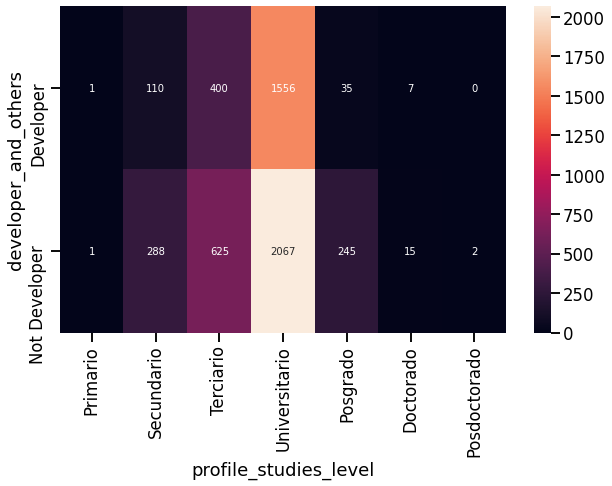

In [ ]:
fig = plt.figure(figsize=(10,6))
exp = pd.crosstab(df.developer_and_others,df.profile_studies_level)[sorted_studies_levels]
seaborn.heatmap(exp, annot=True, fmt='g')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


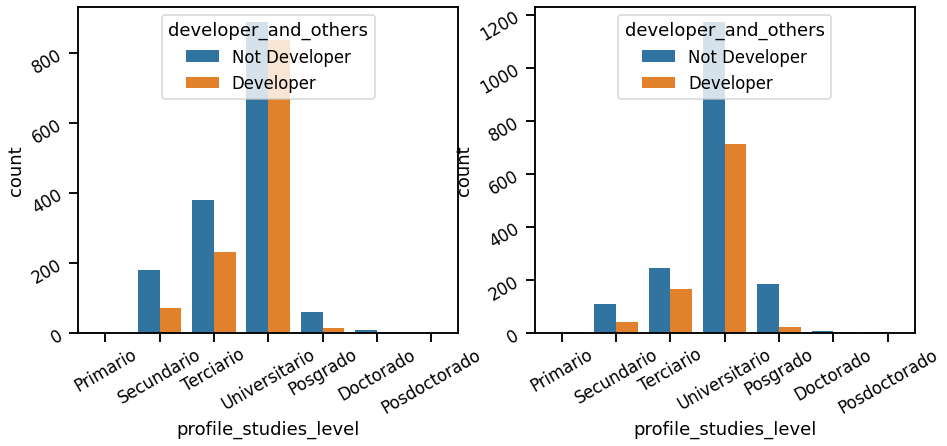

In [ ]:
#fig = plt.figure(figsize=(8,6))
fig, axes = plt.subplots(ncols=2, figsize=(15,6))
g=seaborn.countplot(df[df['salary_monthly_NETO']<media_salary_neto].profile_studies_level,  hue=df.developer_and_others,order=sorted_studies_levels,ax=axes[0] )
g=seaborn.countplot(df[df['salary_monthly_NETO']>media_salary_neto].profile_studies_level,  hue=df.developer_and_others,order=sorted_studies_levels,ax=axes[1] )
#plt.xticks(rotation=45)
for ax in axes:
  ax.tick_params(labelrotation=30)

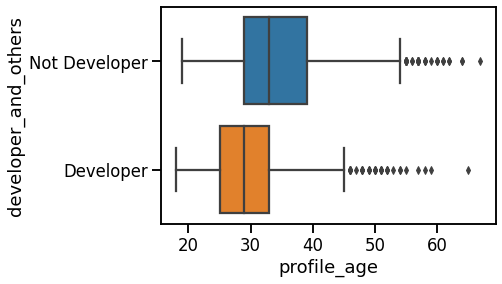

In [ ]:
seaborn.boxplot(data=df,x='profile_age',y='developer_and_others')

####Caso 2:Años de Experiencia vs Nivel de Estudio vs Salario Neto.
Analizaremos estas variables con la idea de entender si los salarios tienen relación con la experencia y el nivel de estudio. 


In [ ]:
#retiramos los salarios en USD. 
df=df[df['salary_in_usd']=='No']

Con el ds sin outliers y sin salarios en usd, realizamos un catplot donde comparamos salarios netos vs años de experiencia para cada nivel de estudio. Es interesante observar (y quizás podríamos decir que cae dentro de lo esperado) que los niveles superiores de estudio brindan salarios más altos en todo el ciclo de vida profesional. Los niveles de estudio que incluyen secundario y terciario brindan excelentes salarios al principio (donde todos son desarrolladores de expertise inicial) pero no acompañan a los ingresos de los niveles superiores a medida que pasan los años de experiencia. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


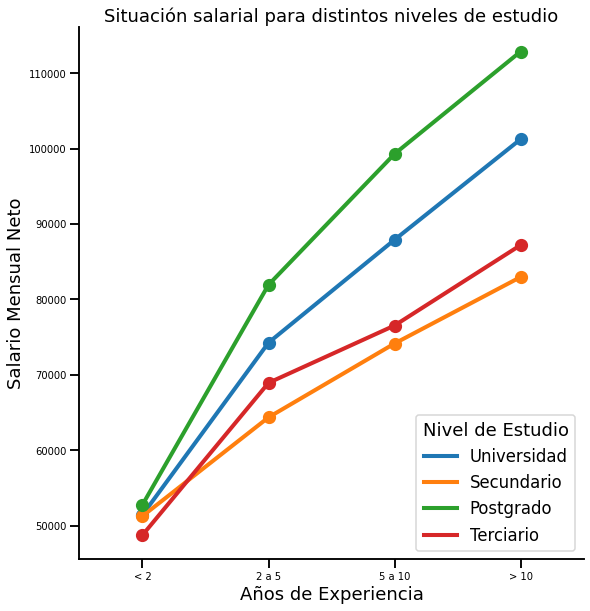

In [ ]:
#seleccionamos los perfiles que incluyen una cantidad importante de muestras.
perfiles=['Universitario','Secundario','Terciario','Posgrado']
df_perfiles = df[df['profile_studies_level'].isin(perfiles)]
#generamos una nueva columan con los años de exp agrupados para "categorizar" la variable.
df_perfiles["group_years_exp"] = pd.cut(df_perfiles.profile_years_experience, bins=[0,2,5,10,30],labels=['< 2','2 a 5','5 a 10','> 10'],right=True,include_lowest=True)
#control
#df_without_percentil.group_years_exp.value_counts()
graph=seaborn.catplot(x="group_years_exp", y="salary_monthly_NETO", hue="profile_studies_level",
            kind="point", 
            data=df_perfiles,
            ci=None,
            height=8, aspect=1,
            legend=False
            )
graph.set(xlabel ="Años de Experiencia", ylabel = "Salario Mensual Neto", title ='Situación salarial para distintos niveles de estudio')
#plt.legend(labels=['1','2','3','4'])
plt.legend(['Universidad', 'Secundario', 'Postgrado','Terciario'],title='Nivel de Estudio',loc='lower right')

###Análisis de variables numéricas

Se analizaran las siguientes 3 variables numéricas: wors_years_in_company, salary_monthly_NETO y profile_years_experience. El motivo de estas variables es evaluar si por un lado los años en la empresa y los años de experiencia tienen correlación. Si tengo muchos años en la empresa y es igual a los años de experiencia, daría idea de poca rotación?. Respecto a los salarios, si exite relación con la antiguedad y la experiencia. 

De la matriz de corelación solo podríamos decir que existe algún tipo de relación entre los años en la empresa y los años de experiencia. Estaría bueno (y queda fuera del scope de este trabajo) profundizar respecto a la rotación de personal en este rubro que, según se comenta, es alta. 

El pairplot nos brinda las siguientes conclusiones:
1. Que hay muchos casos con muchos años de experiencia y pocos a años en empresas. Han sido por mucho tiemppo freelance y hoy bajo relación de dependencia? mucha rotación? 
2. No arroja algún otro tipo de relación que la correlación no detecte. 
3. Extrañamente los años de experencia, por si solos, no dan mejores salarios. (en el sentido que debe haber otra variable que si se relaciona con mejores salarios., 

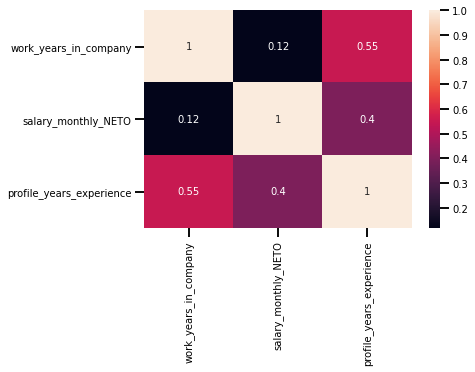

In [ ]:
correlation_mat=df[['work_years_in_company','salary_monthly_NETO','profile_years_experience']].corr()
seaborn.heatmap(correlation_mat, annot = True)
plt.show()

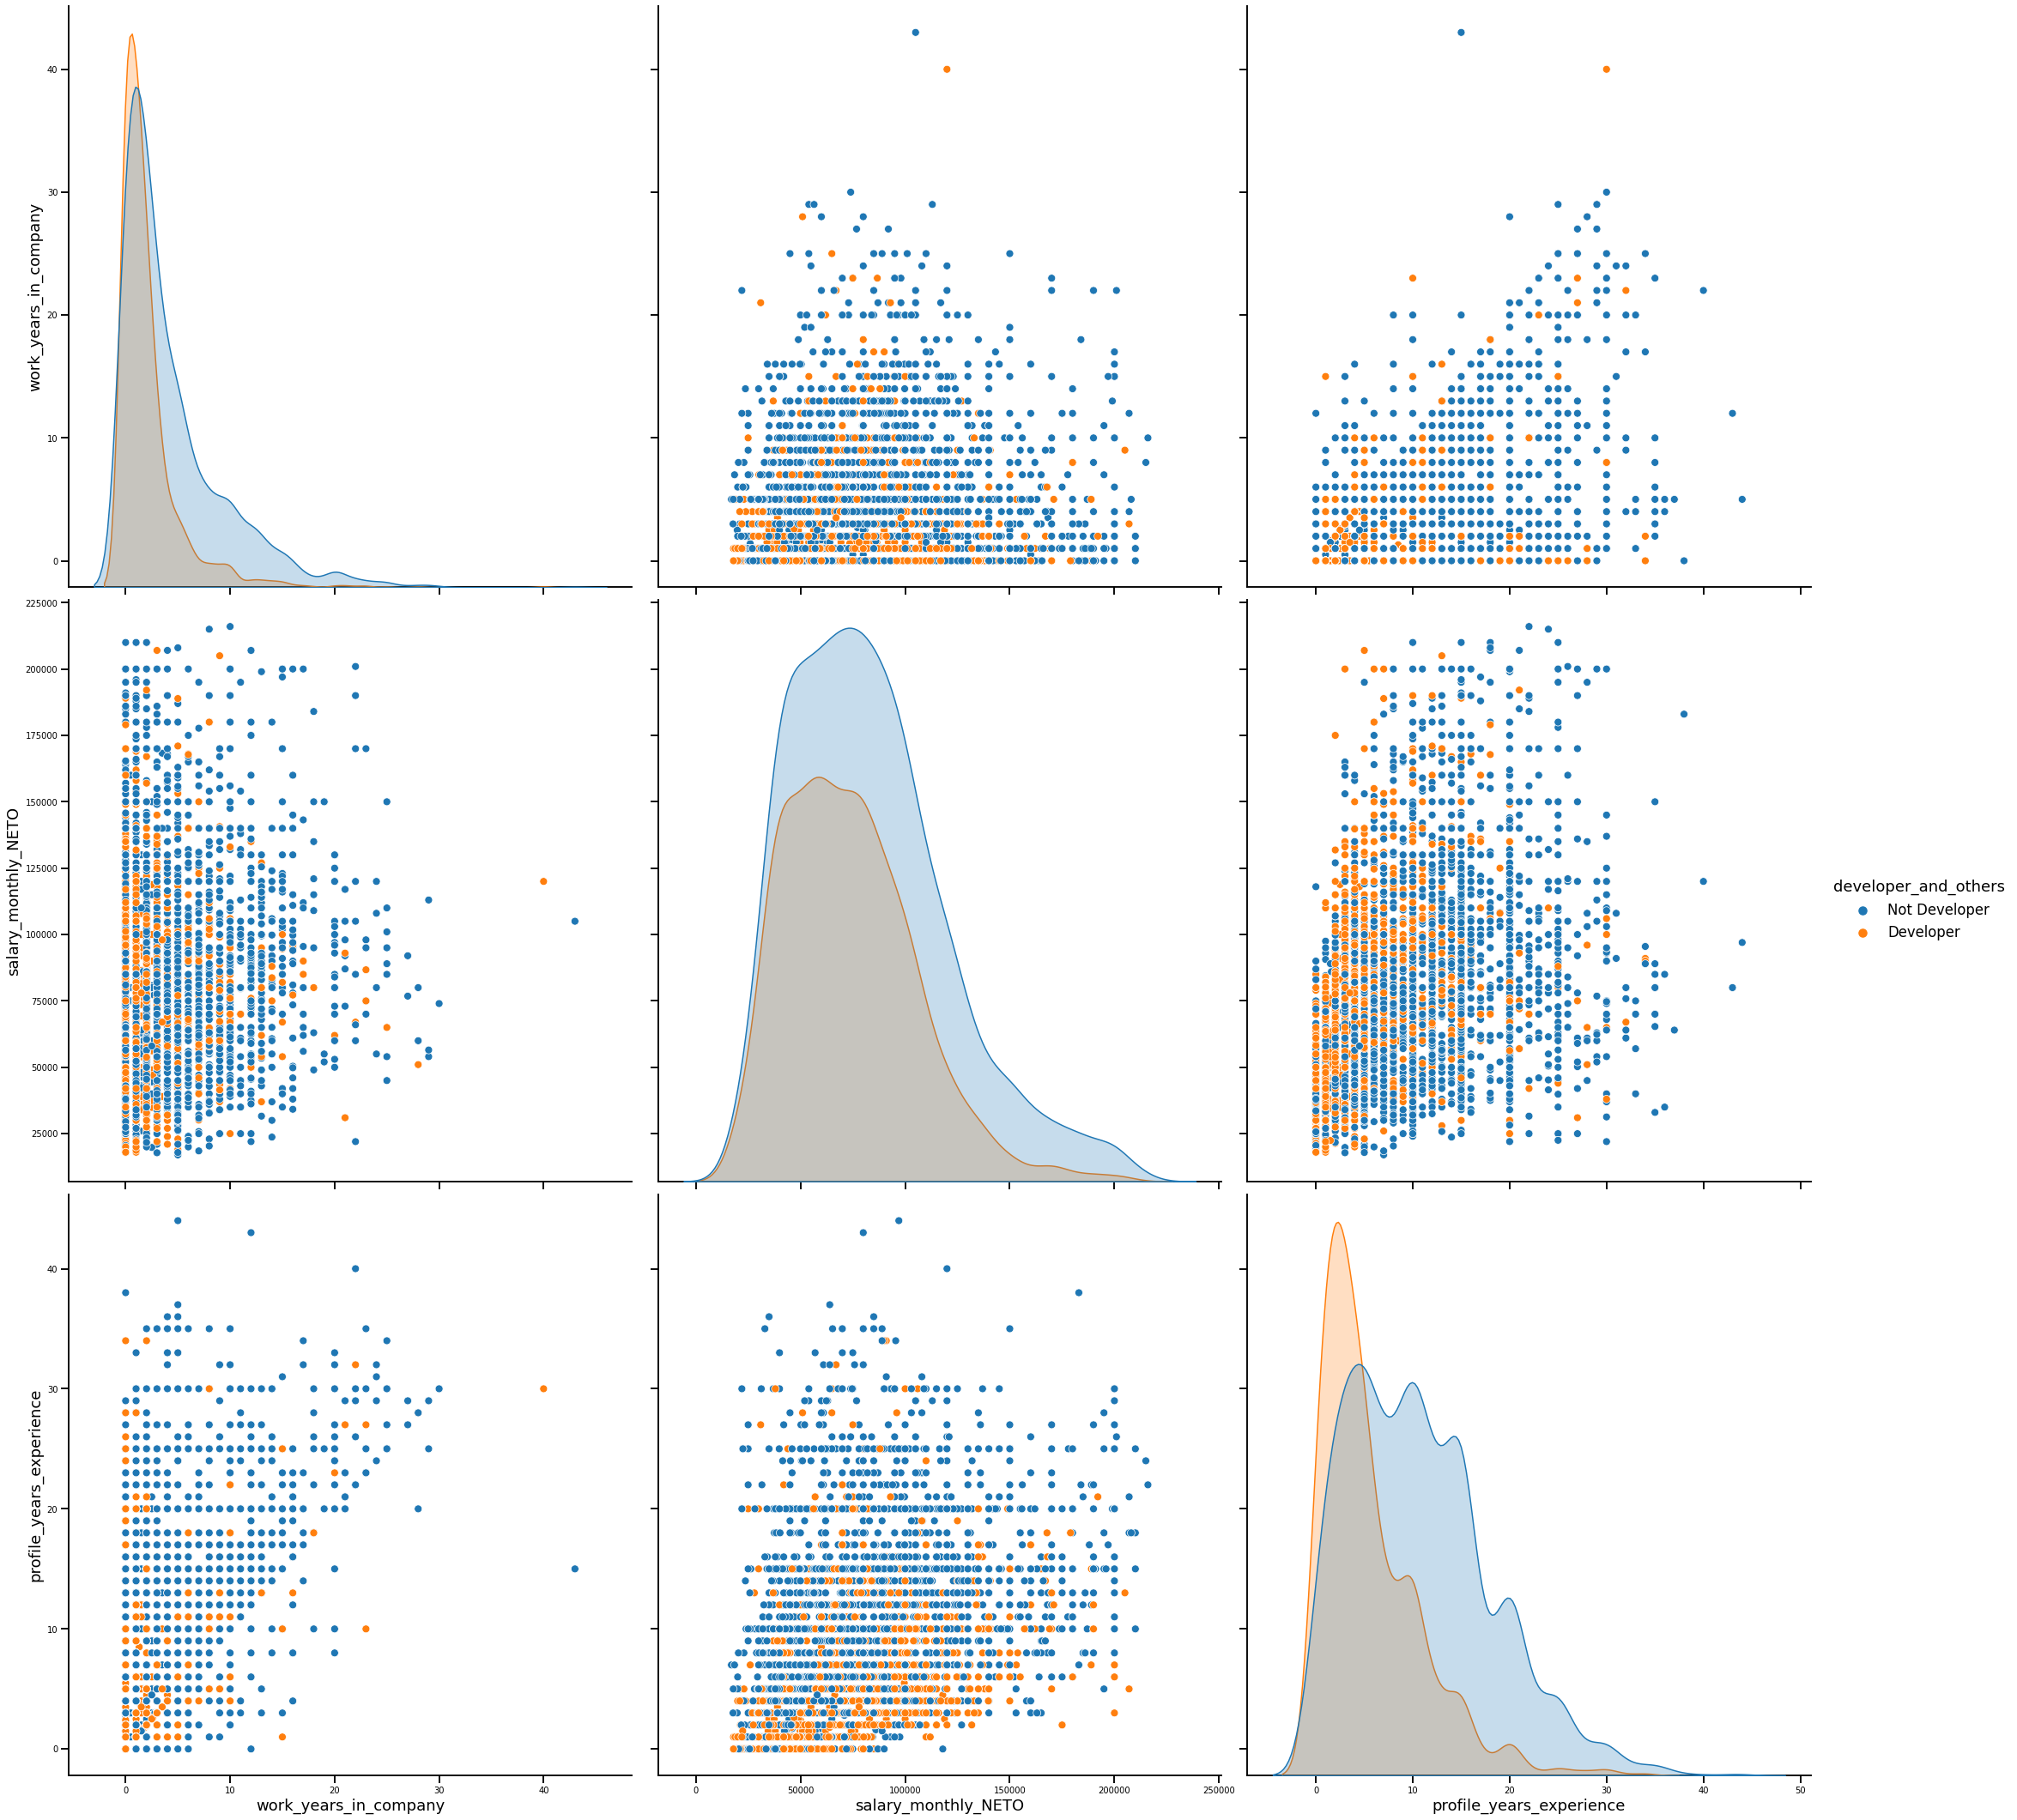

In [ ]:
seaborn.pairplot(df, vars=['work_years_in_company','salary_monthly_NETO','profile_years_experience'], hue='developer_and_others',height=10)

##**Asociación**
Necesitamos decidir si sacar o no la columna de salario bruto. Para hacer la encuesta más simple. ¿Existe una correlación entre el salario bruto y el neto? Que abordaje y medidas usaría

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


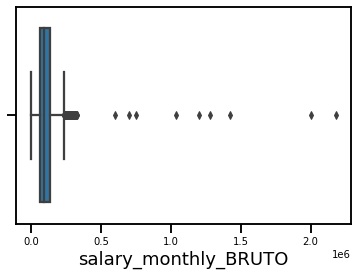

In [ ]:
#observacion de outlier en salario Bruto. 
seaborn.boxplot(df.salary_monthly_BRUTO)

In [ ]:
#eliminamos el percentil 95 del salario BRUTO, porque afecta a la visualización a continuación con datos muy extremos. 
percentile_95 = df['salary_monthly_BRUTO'].quantile(95 / 100)
df=df[df['salary_monthly_BRUTO'] < percentile_95]

En el siguiente scatter graficamos salario NETO vs salario BRUTO. Además incluimos 3 curvas más: f(x)=x, f(x)=1.17x, f(x)=1.5x

La primera curva, verde en el gráfico, es cuando NETO y BRUTO son iguales. Podría ser el caso de freelance. 
El segundo scatterplot incluye solo freelance; aqui nos preguntamos, ¿Qué incluye en el bruto un freelance?. Podría ser obra social, seguros de vida, entre otras opciones. 
La segunda curva, en rojo, es el porcentaje mínimo (1.17) de un empleado en relación de dependencia. Y entendemos que puede llegar a 1.5 (curva amarilla) y hasta superarlo, dependiendo de, por ejemplo, una obra social prepaga para todo su grupo familiar. 
Los valores por dejabo de la curva verde no tienen mucha lógica: NETO > BRUTO y equivalen al 2.65%. 

In [ ]:
#salarios NETO > BRUTO, que no tienen lógica. 
100*len(df[(df.salary_monthly_NETO) > (df.salary_monthly_BRUTO)])/len(df)

2.765369070410551

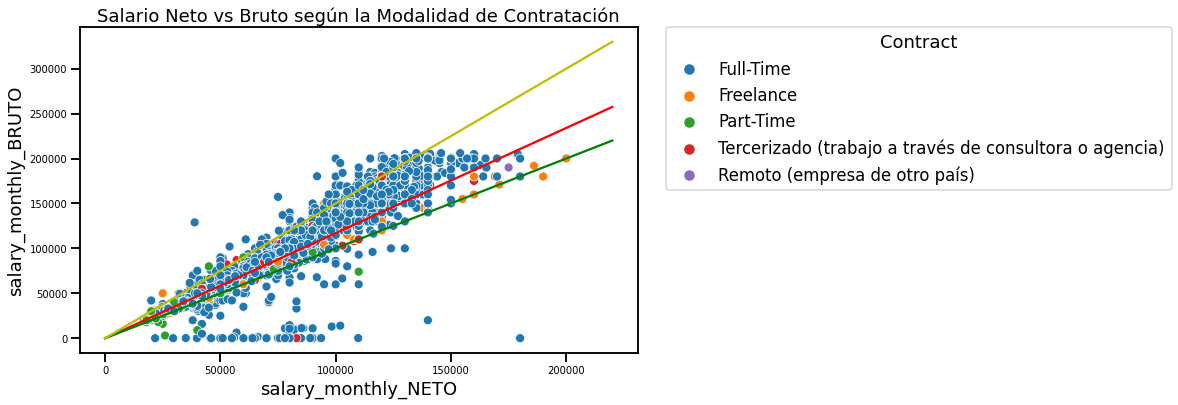

In [ ]:
plt.figure(figsize = (10,6))
plt.title("Salario Neto vs Bruto según la Modalidad de Contratación", fontsize=18)
seaborn.scatterplot(data = df, x = 'salary_monthly_NETO', y = 'salary_monthly_BRUTO', hue = 'work_contract_type')
plt.legend(bbox_to_anchor = (1.05,1),loc = 2,borderaxespad = 0., title = 'Contract')
X_plot = np.linspace(0,220000)
Y_plot = X_plot*1.17
plt.plot(X_plot, Y_plot, color='r')
Y2_plot = X_plot
plt.plot(X_plot, Y2_plot, color='g')
Y3_plot = X_plot*1.5
plt.plot(X_plot, Y3_plot, color='y')
plt.show()

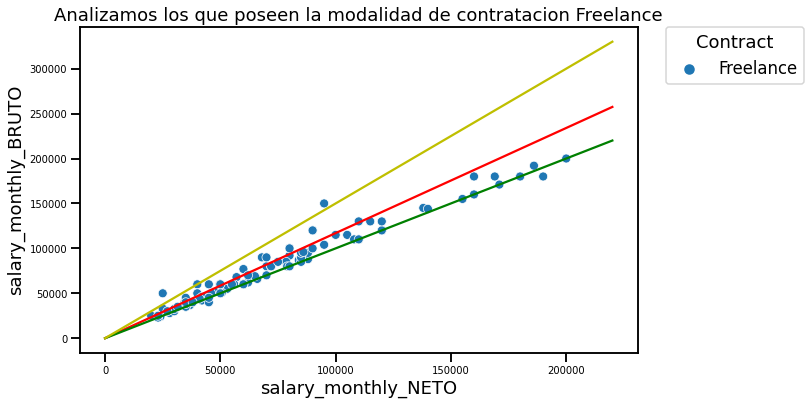

In [ ]:
plt.figure(figsize = (10,6))
solo_freelance=df[df['work_contract_type']=='Freelance']
seaborn.scatterplot(data = solo_freelance, x = 'salary_monthly_NETO',y = 'salary_monthly_BRUTO', hue = 'work_contract_type')
plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.,title='Contract')
plt.title("Analizamos los que poseen la modalidad de contratacion Freelance", fontsize=18)
X_plot = np.linspace(0,220000)
Y_plot = X_plot*1.17
plt.plot(X_plot, Y_plot, color='r')
Y2_plot = X_plot
plt.plot(X_plot, Y2_plot, color='g')
Y3_plot = X_plot*1.5
plt.plot(X_plot, Y3_plot, color='y')
plt.show()

Como respuesta a la consigna incluiríamos el salario Bruto, pero para la subpoblación de full time con Bruto >= NETO. Los mismos corresponden al 84% de los datos. Entendemos que la información de los 2 salarios es importante si el objeto de investigación es conocer los aportes tributarios y obligatorios de los encuestados y su efecto en los distintos tipos de contratación. 

##Densidad Condicional

Estudie la distribución del salario según el nivel de estudio.

Separe la población según el nivel de estudio (elija dos subpoblaciones numerosas) y grafique de manera comparativa ambos histogramas de la variable 'salary_monthly_NETO' ¿Considera que ambas variables son independientes? ¿Qué analizaría al respecto?

Calcule medidas de centralización y dispersión para cada subpoblación

In [ ]:
df.profile_studies_level.value_counts(normalize=False)

Universitario    3142
Terciario         939
Secundario        360
Posgrado          237
Doctorado          19
Posdoctorado        2
Primario            2
Name: profile_studies_level, dtype: int64

Se seleccionan las dos subpoblaciones mas numerosas de la variable aleatoria profile_studies_level "Universitarios y Terciario".

In [ ]:
#Se genera una nueva variable (Columna) donde se indica nivel de estudio Universitario y Terciaro, los que no entran en esa categoria se le coloca NA para luego eliminarlos, por no ser objeto de estudio.
df['Universitarios_and_Terciarios']=np.where(df['profile_studies_level']=='Universitario','Universitario',np.where(df['profile_studies_level']=='Terciario','Terciario','NA'))
pd.crosstab(df.Universitarios_and_Terciarios, df.profile_studies_level)#, normalize=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


profile_studies_level,Doctorado,Posdoctorado,Posgrado,Primario,Secundario,Terciario,Universitario
Universitarios_and_Terciarios,,,,,,,
NA,19,2,237,2,360,0,0
Terciario,0,0,0,0,0,939,0
Universitario,0,0,0,0,0,0,3142


Se crea DF solo con universitarios y terciarios; eliminamos registros nulos y filtramos los valores de acuerdo al cuantil 0,95

In [ ]:
salary_col='salary_monthly_NETO'
df_univ_terc=df.copy()
df_univ_terc=df_univ_terc.drop(df_univ_terc[df_univ_terc['Universitarios_and_Terciarios']=="NA"].index)
df_univ_terc=df_univ_terc[df_univ_terc[salary_col] < percentile_95]
df_univ_terc.head()

,profile_gender,profile_age,work_country,work_province,profile_years_experience,work_years_in_company,work_years_in_current_position,work_people_in_charge_of,profile_studies_level,profile_studies_level_state,profile_career,profile_university,profile_specialization_courses,profile_open_source_contributions,profile_programming_as_hobby,work_role,tools_platform,tools_programming_languages,tools_frameworks,tools_data_bases,tools_qa_testing,tools_IDEs,tools_work_pc_os,tools_cellphone_os,work_on_call_duty,salary_on_call_duty_charge,work_on_call_duty_charge_type,work_contract_type,salary_monthly_BRUTO,salary_monthly_NETO,salary_in_usd,salary_satisfaction,salary_comparison_last_semester,salary_has_bonus,salary_bonus_tied_to,salary_inflation_adjustment_2020,salary_percentage_inflation_adjustment_2020,salary_month_last_inflation_adjustment,work_has_violence_situations,profile_sexual_orientation,profile_has_disabilities,profile_has_disabilities_hiring_difficulties,company_employee_number,company_main_activity,company_recommended,company_diversity_policies,company_extra_benefits,company_best_companies_city,developer_and_others,Universitarios_and_Terciarios
0,Mujer,26,Argentina,Ciudad Autónoma de Buenos Aires,3.0,3.0,3.0,0,Universitario,En curso,Ingeniería en Sistemas de Información,UTN - Universidad Tecnológica Nacional,"Sí, los pagó un empleador",No,Sí,Consultant,Ninguna,Ninguno,Ninguno,Ninguna,Ninguna,Ninguno,GNU/Linux,Android,No,0.0,Bruto,Full-Time,53000.0,43000.0,No,1,1,No,No recibo bono,No,0.0,0,En mi trabajo actual,Homosexual,NaN,NaN,501-1000,Servicios / Consultoría de Software / Digital,7,2,"Capacitaciones y/o cursos, Comidas pagas / sub...",NaN,Not Developer,Universitario
1,Hombre,29,Argentina,Corrientes,5.0,2.0,2.0,4,Universitario,En curso,Ingeniería en Sistemas de Información,UTN - Universidad Tecnológica Nacional,"Sí, de forma particular, Sí, los pagó un emple...",No,Sí,Developer,"Docker, Google Cloud Platform/App Engine","HTML, Javascript, Python","Django, jQuery","Informix, MySQL, PostgreSQL",Ninguna,"IPython / Jupyter, Sublime Text, Visual Studio...",GNU/Linux,Android,No,0.0,Bruto,Full-Time,79000.0,63000.0,No,2,2,Menos de un sueldo,Performance de la compañía,Uno,10.0,1,Jamás,Heterosexual,Visual,No,201-500,Otras industrias,8,9,"Horarios flexibles, Stock options / RSUs, Viát...",NaN,Developer,Universitario
4,Hombre,32,Argentina,Ciudad Autónoma de Buenos Aires,9.0,6.0,6.0,0,Universitario,En curso,Licenciatura en Ciencias dela Computación,UBA - Universidad de Buenos Aires,No,No,Sí,Developer,Amazon Web Services,"CSS, HTML, Javascript, SQL, TypeScript","Angular, Node.js","Amazon DynamoDB, MongoDB, MySQL",Jest,Vim,macOS,Android,No,0.0,Porcentaje de mi sueldo,Full-Time,140000.0,106000.0,No,1,1,Menos de un sueldo,Performance individual,No,0.0,0,Jamás,Heterosexual,NaN,NaN,11-50,Servicios / Consultoría de Software / Digital,6,6,"Clases de idiomas, Horarios flexibles, Vacacio...",NaN,Developer,Universitario
5,Hombre,25,Argentina,Ciudad Autónoma de Buenos Aires,1.0,0.0,0.0,0,Terciario,Incompleto,Tecnicatura Superior en Programación,UTN - Universidad Tecnológica Nacional,No,No,Sí,Developer,Ninguna,"Java, Javascript","Node.js, React.js, Spark",MySQL,"Jest, JUnit, Postman","IntelliJ, Visual Studio Code",macOS,Android,No,0.0,Bruto,Full-Time,54000.0,44000.0,No,2,2,No,No recibo bono,Uno,15.0,5,Jamás,Heterosexual,NaN,No,10001+,Producto basado en Software,8,8,"Clases de gimnasia online, Clases de idiomas, ...",NaN,Developer,Terciario
6,Hombre,33,Argentina,Ciudad Autónoma de Buenos Aires,1.0,1.0,1.0,0,Universitario,Incompleto,Ingeniería en Informática,UBA - Universidad de Buenos Aires,"Sí, de forma particular, Sí, los pagó un emple...",Sí,Sí,Developer,"Amazon Web Services, Docker, Linux, Serverless",Javascript,Node.js,"MongoDB, MySQL, Redis",Postman,Visual Studio Code,GNU/Linux,Android,No,0.0,Porcentaje de mi sueldo,Full-Time,75000.0,62400.0,No,3,3,No,No recibo bono,Dos,8.0,4,Jamás,Heterosexual,NaN,NaN,51-100,Producto basado en Software,7,7,"Capa

Mostramos un histograma comparativo entre salario neto y nivel de estudio incluyendo la subpoblacion seleccionada.

No handles with labels found to put in legend.


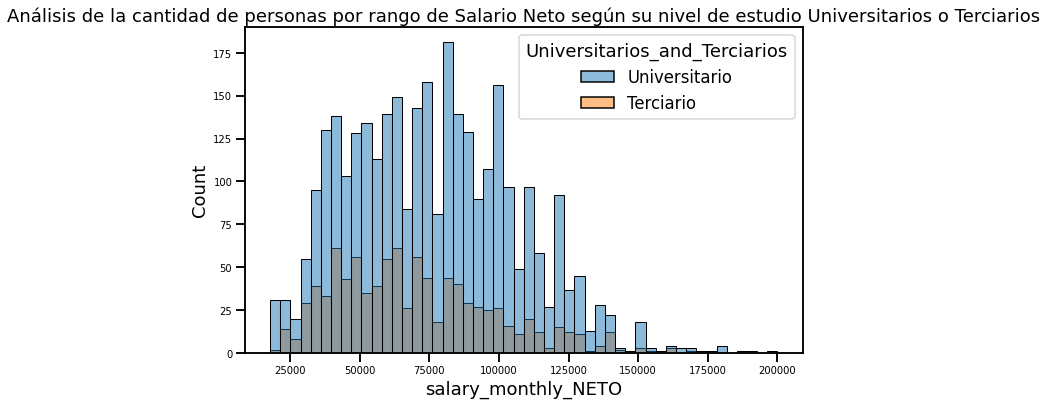

In [ ]:
plt.figure(figsize=(10,6))
plt.legend(loc="right")
plt.title("Análisis de la cantidad de personas por rango de Salario Neto según su nivel de estudio Universitarios o Terciarios", fontsize=18)
seaborn.histplot(df_univ_terc, x="salary_monthly_NETO", hue="Universitarios_and_Terciarios", bins=50)

En el gráfico anterior observamos que hay mayor cantidad de Universitarios a lo largo de la muestra utilizada, pero con distribuciones smilares respecto al salario neto.

A continuación se realiza grafico de caja relacionando las subpoblaciones seleccionadas con su salario neto


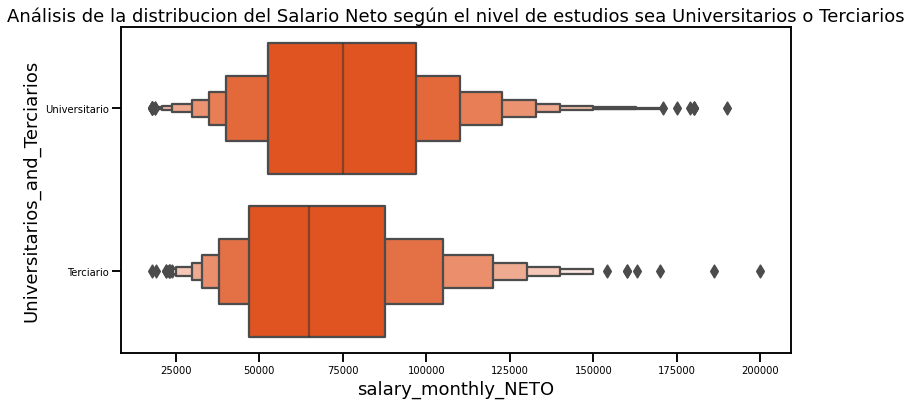

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("Análisis de la distribucion del Salario Neto según el nivel de estudios sea Universitarios o Terciarios", fontsize=18)
seaborn.boxenplot(data=df_univ_terc, x='salary_monthly_NETO', y='Universitarios_and_Terciarios',color='orangered')
plt.ticklabel_format(style='plain', axis='x')

Se observa que la distribucion de ambas subpoblaciones son similares, en el caso de los Universitarios se logra salario mayores.



Para el analisis se agrega una nueva variable aleatoria categorica en relacion al salario neto, es "is_above_avg_salary_neto", donde se indica si el salario es mayor al promedio, lo valores posibles son "Si" y "No"

In [ ]:
#Se agrega la nueva variable aleatoria is_above_avg_salary_neto

avg_salary=df_univ_terc.salary_monthly_NETO.mean()
df_univ_terc['is_above_avg_salary_neto']=np.where(df_univ_terc['salary_monthly_NETO'] > avg_salary,'Si','No')


In [ ]:
#Calculo probabilidad de tener nivel de estudio Universitario
p_universitario = len(df_univ_terc[df_univ_terc['Universitarios_and_Terciarios']=="Universitario"]) / len(df_univ_terc)
avg_salary=df_univ_terc.salary_monthly_NETO.mean()
p_universitario


0.7699093359470718

In [ ]:
#Calculo probabilidad de ganar mas que el promedio del salario neto
p_above_avg = len(df_univ_terc[df_univ_terc['salary_monthly_NETO'] >= avg_salary]) / len(df_univ_terc)
p_above_avg

0.4783141386914972

In [ ]:
#Calculamos la probabilidad de ser universitario y ganar mas del salario neto promedio
is_above_avg = df_univ_terc['salary_monthly_NETO'] > avg_salary
study_level_univ = df_univ_terc.Universitarios_and_Terciarios=="Universitario"
p_intersection_count = len(df_univ_terc[is_above_avg & study_level_univ])/len(df_univ_terc)
p_intersection_count

0.3901004655721637

In [ ]:
#Calculamos la probabilidad de ser terciario y ganar mas del salario neto promedio
is_above_avg = df_univ_terc['salary_monthly_NETO'] > avg_salary
study_level_univ = df_univ_terc.Universitarios_and_Terciarios=="Terciario"
p_intersection_count_terciario = len(df_univ_terc[is_above_avg & study_level_univ])/len(df_univ_terc)
p_intersection_count_terciario

0.0882136731193335

In [ ]:
#Calculamos la probabilidad de ser terciario y ganar menos del salario neto promedio
is_above_avg = df_univ_terc['salary_monthly_NETO'] < avg_salary
study_level_univ = df_univ_terc.Universitarios_and_Terciarios=="Terciario"
p_intersection_count_terciario_menos = len(df_univ_terc[is_above_avg & study_level_univ])/len(df_univ_terc)
p_intersection_count_terciario_menos

0.1418769909335947

In [ ]:
#Calculamos la probabilidad de ser universitario y ganar menos del salario neto promedio
is_above_avg = df_univ_terc['salary_monthly_NETO'] < avg_salary
study_level_univ = df_univ_terc.Universitarios_and_Terciarios=="Universitario"
p_intersection_count_menos = len(df_univ_terc[is_above_avg & study_level_univ])/len(df_univ_terc)
p_intersection_count_menos

0.3798088703749081

Verificamos la condicion de independencia planteada.

¿Considera que ambas variables son independientes? ¿Qué analizaría al respecto?
Se realiza el siguiente planteo:

Sean A y B se dicen conjuntos independientes si:

P(A∩B)=P(A)P(B)

Calculamos la probabilidad de ser universitario y ganar mas del salario neto promedio.

P(A∩B)=0.38561347598452084

P(A)P(B)=0.7776007284315957x0.4693831094923742=0.364989888


No se cumple la condicion de independencia, nos da una idea de que las variables estan relacionadas.

P(B)!=0 -> P(A|B)=P(A)


donde P(A|B)=P(A∩B)/P(B)

Test Chi-Cuadrado  p/ independencia de v.a. categóricas

H0=”las dos variables en estudio son independientes”

H1=”las dos variables en estudio están relacionadas”

In [ ]:
#Se realiza la tabla de contingencia
tab_conting = pd.crosstab(df_univ_terc.Universitarios_and_Terciarios, df_univ_terc.is_above_avg_salary_neto)#, margins=true)
tab_conting

is_above_avg_salary_neto,No,Si
Universitarios_and_Terciarios,,
Terciario,579,360
Universitario,1550,1592


Calculamos test chi-cuadrado.

In [ ]:
test= chi2_contingency(tab_conting)

#los valores esperados son:
esperados = pd.DataFrame(test[3])
esperados

,0,1
0,489.863024,449.136976
1,1639.136976,1502.863024


In [ ]:
#P-Valor
print ("el P valor es:", test[1])

el P valor es: 4.129627143895779e-11


Tomando un nivel de significancia aplha=0,05 y contrastando con el P-valor obtenido se concluye que se rechaza la hipotesis H0, las variables comparadas no son independientes.

Calculo de medidas de centralizacion y dispersion para cada subpoblacion.

In [ ]:
#calculamos la media, mediana y maximo del Salario Neto con nivel estudio Terciario
medidas_centralizacion_univ=df_univ_terc[df_univ_terc['Universitarios_and_Terciarios']=='Terciario'].salary_monthly_NETO.mean(), df_univ_terc[df_univ_terc['Universitarios_and_Terciarios']=='Terciario'].salary_monthly_NETO.median(), df_univ_terc[df_univ_terc['Universitarios_and_Terciarios']=='Terciario'].salary_monthly_NETO.max()
print("Media, Mediana, Maximo")
medidas_centralizacion_univ

Media, Mediana, Maximo


(69961.36443024494, 65000.0, 200000.0)

In [ ]:
#calculamos la media y mediana del Salario Neto con nivel estudio Univercitario
medidas_centralizacion_terc=df_univ_terc[df_univ_terc['Universitarios_and_Terciarios']=='Universitario'].salary_monthly_NETO.mean(), df_univ_terc[df_univ_terc['Universitarios_and_Terciarios']=='Universitario'].salary_monthly_NETO.median(), df_univ_terc[df_univ_terc['Universitarios_and_Terciarios']=='Universitario'].salary_monthly_NETO.max()
print("Media, Mediana, Maximo")
medidas_centralizacion_terc

Media, Mediana, Maximo


(75840.82232017825, 75000.0, 190000.0)

In [ ]:
#Medidas de dispersion
df_univ_terc[df_univ_terc['Universitarios_and_Terciarios']=='Universitario'].salary_monthly_NETO.describe()

count      3142.00000
mean      75840.82232
std       29566.29689
min       17800.00000
25%       52500.00000
50%       75000.00000
75%       97000.00000
max      190000.00000
Name: salary_monthly_NETO, dtype: float64

In [ ]:
df_univ_terc[df_univ_terc['Universitarios_and_Terciarios']=='Terciario'].salary_monthly_NETO.describe()

count       939.000000
mean      69961.364430
std       28881.579178
min       18000.000000
25%       47000.000000
50%       65000.000000
75%       87639.500000
max      200000.000000
Name: salary_monthly_NETO, dtype: float64

In [ ]:
print("Coeficiente de variación salario neto de los Terciario",
      scipy.stats.variation(df_univ_terc[df_univ_terc['Universitarios_and_Terciarios']=='Terciario'].salary_monthly_NETO))
print("Coeficiente de variación salario neto de los Universitarios",
      scipy.stats.variation(df_univ_terc[df_univ_terc['Universitarios_and_Terciarios']=='Universitario'].salary_monthly_NETO.dropna()))

Coeficiente de variación salario neto de los Terciario 0.4126019612887217
Coeficiente de variación salario neto de los Universitarios 0.38978469113210007


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


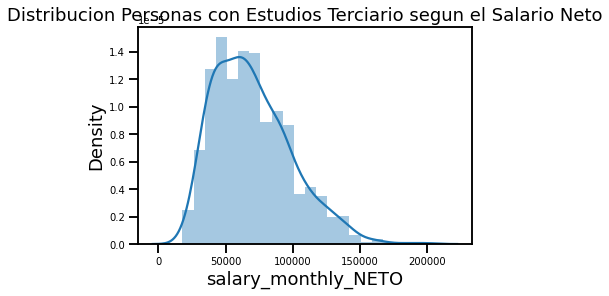

In [ ]:
plt.title("Distribucion Personas con Estudios Terciario segun el Salario Neto")
seaborn.distplot(df_univ_terc[df_univ_terc['Universitarios_and_Terciarios']=='Terciario'].salary_monthly_NETO)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


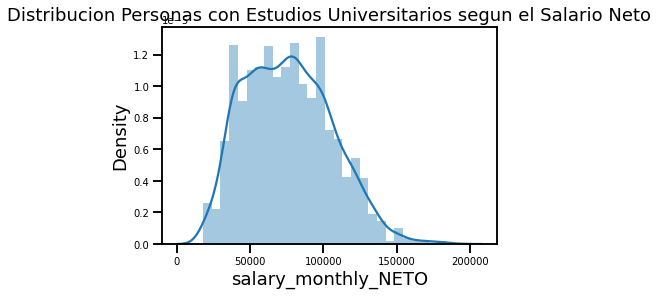

In [ ]:
plt.title("Distribucion Personas con Estudios Universitarios segun el Salario Neto")
seaborn.distplot(df_univ_terc[df_univ_terc['Universitarios_and_Terciarios']=='Universitario'].salary_monthly_NETO)

En general se observa que ambas subpoblaciones tienen distribuciones similares con desviacion estandar y coeficiente de variacion aproximadas respecto al salario neto. La subpoblacion Universitarios tiene mas personas dentro de los encuestados. En promedio los Universitarios tienen mayor sueldo que los Terciarios aunque el salario maximo obtenido es similar dentro del percentil 90 de la variable salario neto.


##Densidad Conjunta condicional

Elija dos variables numéricas y una categórica. Estudie la dispersión (scatterplot) de las dos variables discriminando en color por la variable categórica (ayuda: hue en seaborn)

Se selecciona variable categorica is_above_avg_salary_neto, y las numericas profile_years_experience, salary_monthly_NETO.

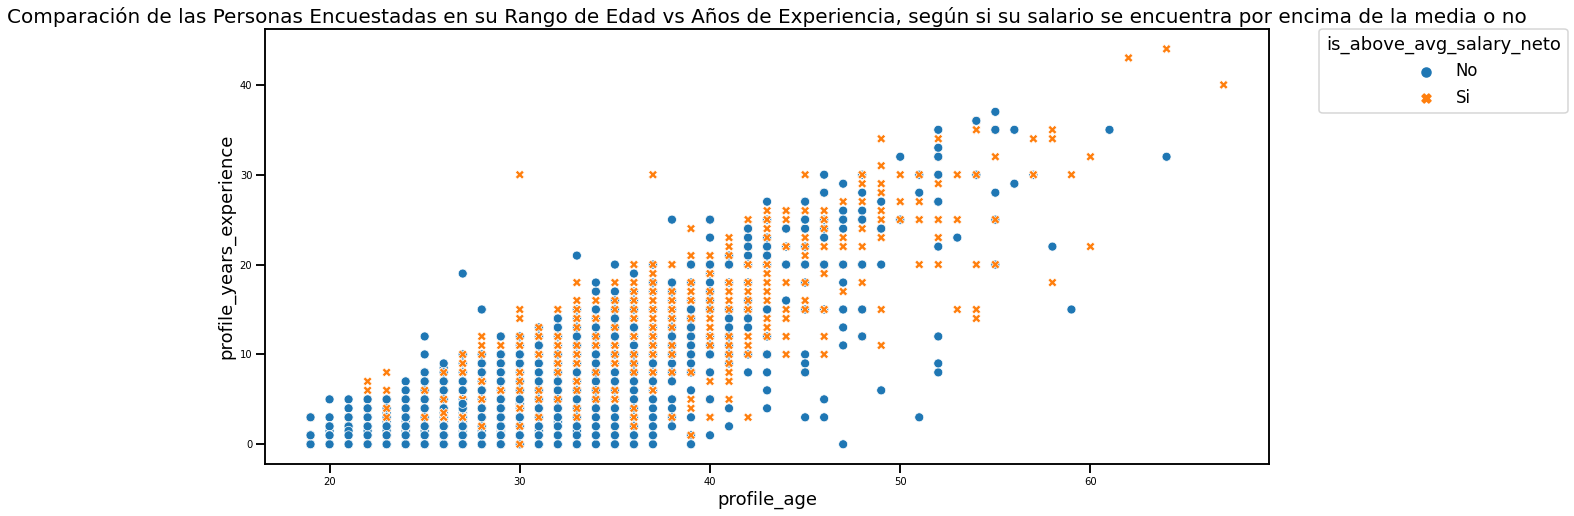

In [ ]:
edad=df_univ_terc[df_univ_terc['profile_age']<70]
plt.figure(figsize=(18,8))
plt.title("Comparación de las Personas Encuestadas en su Rango de Edad vs Años de Experiencia, según si su salario se encuentra por encima de la media o no", fontsize=20)
seaborn.scatterplot(data=edad,x='profile_age',y='profile_years_experience',hue='is_above_avg_salary_neto',style='is_above_avg_salary_neto')
plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.,title='is_above_avg_salary_neto')

Se observa que las personas con mas de 10 años experiencia laboral tienen en su mayoria mas de 30 años y obtienen sueldos mayor al sueldo neto promedio.